In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [12]:
conda install -c conda-forge openjpeg

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install GDCM

Note: you may need to restart the kernel to use updated packages.


In [1]:
import glob
import cv2
import skimage.io as io
import numpy as np
import pandas as pd
import pydicom
import pydicom.data
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut

import os
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

C:\Users\Zehra\anaconda3\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
from keras.applications import vgg16
img_rows,img_cols=224,224
model=vgg16.VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(img_rows,img_cols,3))

In [3]:
for layer in model.layers:
    layer.trainable=False #katmanları dondur
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
def layer_adder(bottom_model,num_classes):
    top_model=bottom_model.output
    top_model=GlobalAveragePooling2D()(top_model)
    top_model=Dense(1024,activation='relu')(top_model)
    top_model=Dense(512,activation='relu')(top_model)
    top_model=Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [5]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,GlobalAveragePooling2D
from keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
num_classes=3#inmeyok,iskemi,kanama
FC_Head=layer_adder(model,num_classes)
model=Model(inputs=model.input,outputs=FC_Head)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
from keras.preprocessing.image import ImageDataGenerator
path=r'C:\\Users\\Zehra\\Desktop\\NEWSET\\'
train_data_dir= path+'train\\'
validation_data_dir= path+ 'val\\'
test_data_dir=path+'test\\'
train_datagen=ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen=ImageDataGenerator(rescale=1./255)
batch_size=16
train_generator=train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    class_mode='categorical')
validation_generator=validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    class_mode='categorical')
test_datagen=ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_rows,img_cols),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 202 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Found 100 images belonging to 1 classes.


In [7]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint=ModelCheckpoint('strokevgg16.h15',
                           monitor='val_loss',
                           mod="min",
                           save_best_only=True,
                           verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=3,
                        verbose=1,
                        restore_best_weights=True)
callbacks=[earlystop,checkpoint]
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
epochs=1
history=model.fit(
             train_generator,
             epochs=epochs,
             callbacks=callbacks,
             validation_data=validation_generator)

13/13 [==============================] - 158s 11s/step - loss: 1.3128 - accuracy: 0.4345 - val_loss: 1.1598 - val_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 1.15975, saving model to strokevgg16.h15
INFO:tensorflow:Assets written to: strokevgg16.h15\assets


In [8]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


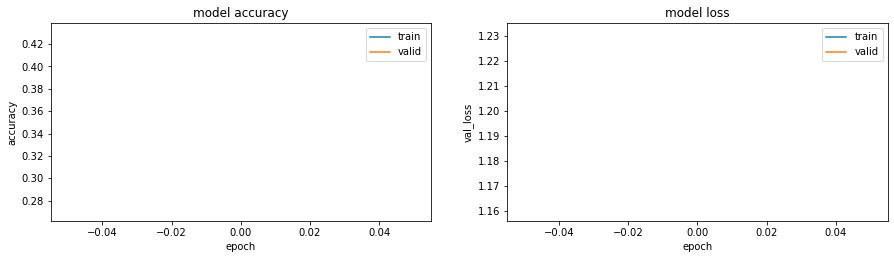

In [9]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['val_accuracy'])  
plt.plot(history.history['accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['val_loss'])  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('val_loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

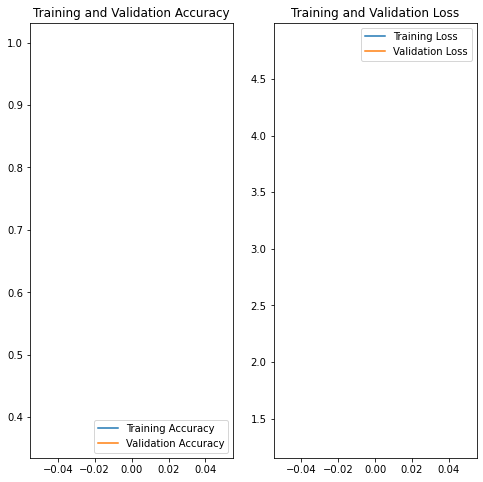

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [71]:
from keras.models import load_model
classifier=load_model('strokevgg16.h15')#modeli yükle

In [143]:
from os import listdir
from os.path import isfile,join

In [144]:
stored_dict={"[0]":"inme yok" , "[1]":"iskemi", "[2]":"kanama"}
stored_dict_n={"[0]":"inme yok" , "[1]":"iskemi", "[2]":"kanama"}

In [146]:
def test_et(name,pred,im):
    brain=stored_dict[str(pred)]
    BLACK=[0,0,0]
    expanded_image=cv2.copyMakeBorder(im,80,0,0,100,cv2.BORDER_CONSTANT,value=BLACK)#Görüntüye kenarlık yapılır
    cv2.putText(expanded_image,brain,(20,60),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)#Görüntünün üstüne test yazısını yazar
    cv2.imshow(name,expanded_image)

In [147]:
def getRandomImage(path):
    #test yolundaki rastgele klasörden rastgele görüntü yüklüyoruz
    folders=list(filter(lambda x:os.path.isdir(os.path.join(path,x)),os.listdir(path)))
    random_directory=np.random.randint(0,len(folders))#rastgele sayıyı üret
    path_class=folders[random_directory]
    print("Class - "+str(path_class))
    file_path=path+'TEST\\'
    file_names=[f for f in listdir(file_path) if isfile(join(file_path,f))]
    random_file_index=np.random.randint(0,len(file_names))
    image_name=file_names[random_file_index]
    return cv2.imread(file_path+""+image_name)

In [151]:
for i in range(0,10):
    input_im=getRandomImage((path+'test\\'))
    input_original=input_im.copy()
    input_original=cv2.resize(input_original,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_LINEAR)
    input_im=cv2.resize(input_im,(520,520),interpolation=cv2.INTER_LINEAR)
    input_im=input_im/255.
    input_im=input_im.reshape(1,520,520,3)
    res=np.argmax(classifier.predict(input_im,1,verbose=1),axis=1)#tahmin alıyoruz
    test_et("Tahmin",res,input_original)
    cv2.waitKey(1)
cv2.destroyAllWindows()

Class - TEST
1/1 [==============================] - 2s 2s/step
Class - TEST
1/1 [==============================] - 2s 2s/step
Class - TEST
1/1 [==============================] - 3s 3s/step
Class - TEST
1/1 [==============================] - 2s 2s/step
Class - TEST
1/1 [==============================] - 3s 3s/step
Class - TEST
1/1 [==============================] - 2s 2s/step
Class - TEST
1/1 [==============================] - 3s 3s/step
Class - TEST
1/1 [==============================] - 2s 2s/step
Class - TEST
1/1 [==============================] - 3s 3s/step
Class - TEST
1/1 [==============================] - 2s 2s/step
